In [1]:
import time
import torch.backends.cudnn as cudnn
from torch import nn
from easydict import EasyDict as edict
from models import Generator, Discriminator, TruncatedVGG19
from datasets import SRDataset
from utils import *
from solver import train

/home/shaw/anaconda3/envs/hw5/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# config
config = edict()
config.csv_folder = './SRDataset'
config.HR_data_folder = './SRDataset/div2k/DIV2K_train_HR'
config.LR_data_folder = './SRDataset/div2k/DIV2K_train_LR_bicubic/X4'
config.crop_size = 96
config.scaling_factor = 4

# Generator parameters
config.G = edict()
config.G.large_kernel_size = 9
config.G.small_kernel_size = 3
config.G.n_channels = 64
config.G.n_blocks = 16

# Discriminator parameters
config.D = edict()
config.D.kernel_size = 3
config.D.n_channels = 64
config.D.n_blocks = 8
config.D.fc_size = 1024

# Learning parameters
config.checkpoint = None # path to model (SRGAN) checkpoint, None if none
config.batch_size = 16 #16
config.start_epoch = 0
config.epochs = 200 #200
config.workers = 16  # 4
config.vgg19_i = 5  # the index i in the definition for VGG loss; see paper
config.vgg19_j = 4  # the index j in the definition for VGG loss; see paper
config.beta = 1e-3  # the coefficient to weight the adversarial loss in the perceptual loss
config.print_freq =100 #50
config.lr = 1e-3

# Default device
config.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cudnn.benchmark = True

In [3]:
if config.checkpoint is None:
    # Generator
    generator = Generator(config)

    # Initialize generator's optimizer
    optimizer_g = torch.optim.Adam(params=filter(lambda p: p.requires_grad, generator.parameters()),
                                   lr=config.lr)

    # Discriminator
    discriminator = Discriminator(config)
    optimizer_d = torch.optim.Adam(params=filter(lambda p: p.requires_grad, discriminator.parameters()),
                                   lr=config.lr)

else:
    checkpoint = torch.load(config.checkpoint)
    config.start_epoch = checkpoint['epoch'] + 1
    generator = checkpoint['generator']
    discriminator = checkpoint['discriminator']
    optimizer_g = checkpoint['optimizer_g']
    optimizer_d = checkpoint['optimizer_d']
    print("\nLoaded checkpoint from epoch %d.\n" % (checkpoint['epoch'] + 1))

In [4]:
# Truncated VGG19 network to be used in the loss calculation
truncated_vgg19 = TruncatedVGG19(i=config.vgg19_i, j=config.vgg19_j)
truncated_vgg19.eval()

/home/shaw/anaconda3/envs/hw5/lib/python3.9/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/shaw/anaconda3/envs/hw5/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


35


TruncatedVGG19(
  (vgg): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1)

In [5]:
# Loss functions
content_loss_criterion = nn.MSELoss()
adversarial_loss_criterion = nn.BCEWithLogitsLoss()

In [6]:
# Move to default device
generator = generator.to(config.device)
discriminator = discriminator.to(config.device)
truncated_vgg19 = truncated_vgg19.to(config.device)
content_loss_criterion = content_loss_criterion.to(config.device)
adversarial_loss_criterion = adversarial_loss_criterion.to(config.device)

In [7]:
# Custom dataloaders
train_dataset = SRDataset(split='train', config=config)
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=config.batch_size,
                                           shuffle=True, 
                                           num_workers=config.workers,
                                           pin_memory=True)

In [8]:
# Epochs
for epoch in range(config.start_epoch, config.epochs):
    # At the halfway point, reduce learning rate to a tenth
    if epoch == int(config.epochs / 2 + 1):
        adjust_learning_rate(optimizer_g, 0.1)
        adjust_learning_rate(optimizer_d, 0.1)
    # One epoch's training
    train(train_loader=train_loader,
          generator=generator,
          discriminator=discriminator,
          truncated_vgg19=truncated_vgg19,
          content_loss_criterion=content_loss_criterion,
          adversarial_loss_criterion=adversarial_loss_criterion,
          optimizer_g=optimizer_g,
          optimizer_d=optimizer_d,
          epoch=epoch,
          device=config.device,
          beta=config.beta,
          print_freq=config.print_freq)
    # Save checkpoint
    torch.save({'epoch': epoch,
                'generator': generator,
                'discriminator': discriminator,
                'optimizer_g': optimizer_g,
                'optimizer_d': optimizer_d},
                'checkpoint_srgan.pth.tar')
                    # Save checkpoint every 10 epoch
    if (epoch+1)%10 == 0 :
        torch.save({'epoch': epoch,
                    'generator': generator,
                    'discriminator': discriminator,
                    'optimizer_g': optimizer_g,
                    'optimizer_d': optimizer_d},
                    'checkpoint_srgan.{}.pth.tar'.format((epoch+1)))

Epoch: [0][0/5000]----Batch Time 4.821 (4.821)----Data Time 2.294 (2.294)----Cont. Loss 0.5714 (0.5714)----Adv. Loss 0.4621 (0.4621)----Disc. Loss 1.4558 (1.4558)
Epoch: [0][100/5000]----Batch Time 0.130 (0.154)----Data Time 0.006 (0.024)----Cont. Loss 0.3130 (0.4421)----Adv. Loss 0.6683 (0.6833)----Disc. Loss 1.0658 (1.1236)
Epoch: [0][200/5000]----Batch Time 0.092 (0.133)----Data Time 0.000 (0.013)----Cont. Loss 0.5109 (0.4257)----Adv. Loss 0.6931 (0.6881)----Disc. Loss 1.0539 (1.0855)
Epoch: [0][300/5000]----Batch Time 0.095 (0.129)----Data Time 0.000 (0.011)----Cont. Loss 0.5050 (0.4244)----Adv. Loss 0.6931 (0.6895)----Disc. Loss 1.1251 (1.0763)
Epoch: [0][400/5000]----Batch Time 0.096 (0.127)----Data Time 0.000 (0.009)----Cont. Loss 0.4170 (0.4181)----Adv. Loss 0.6931 (0.6903)----Disc. Loss 1.0302 (1.0716)
Epoch: [0][500/5000]----Batch Time 0.136 (0.125)----Data Time 0.000 (0.008)----Cont. Loss 0.4746 (0.4113)----Adv. Loss 0.6931 (0.6908)----Disc. Loss 1.0539 (1.0684)
Epoch: [0][6

LOSS

In [1]:
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
data_frame=pd.read_csv('./train 1_loss.csv')
ds = data_frame.groupby('epoch').mean().reset_index()


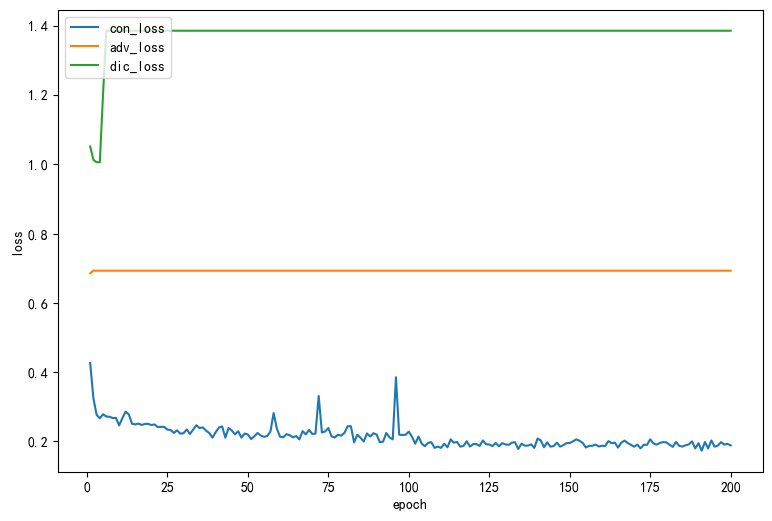

In [3]:
con_loss = ds['con_loss'].to_list()
adv_loss = ds['adv_loss'].to_list()
dic_loss = ds['dic_loss'].to_list()

plt.figure(figsize=(20,6), dpi=100)
plt.rcParams['font.sans-serif']=['SimHei']
plt.subplot(121)
plt.plot(range(1,201), con_loss, label ='con_loss')
plt.plot(range(1,201), adv_loss, label ='adv_loss')
plt.plot(range(1,201), dic_loss, label ='dic_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()
